In [ ]:
!pip3 install torch torchvision

    100% |████████████████████████████████| 591.8MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61b0e000 @  0x7fc7fc9122a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 23.7MB/s 
    100% |████████████████████████████████| 2.0MB 4.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Preparing the CIFAR10 Dataset

This notebook is an extension to the tutorial [Image Classification using CNNs in PyTorch](https://jovian.ai/aakashns/05-cifar10-cnn), where we trained a deep convolutional neural network to classify images from the CIFAR10 dataset with around 75% accuracy. Here are some images from the dataset:

![cifar10](https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png)


Let's begin by downloading the dataset and creating PyTorch datasets to load the data, just as we did in the previous tutorial.

We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [28]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
print(type(training_dataset))
print(type(training_loader))
image, label = training_dataset[1]
print(image.shape)
print(label, type(label))

<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([3, 32, 32])
9 <class 'int'>


In [30]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [31]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

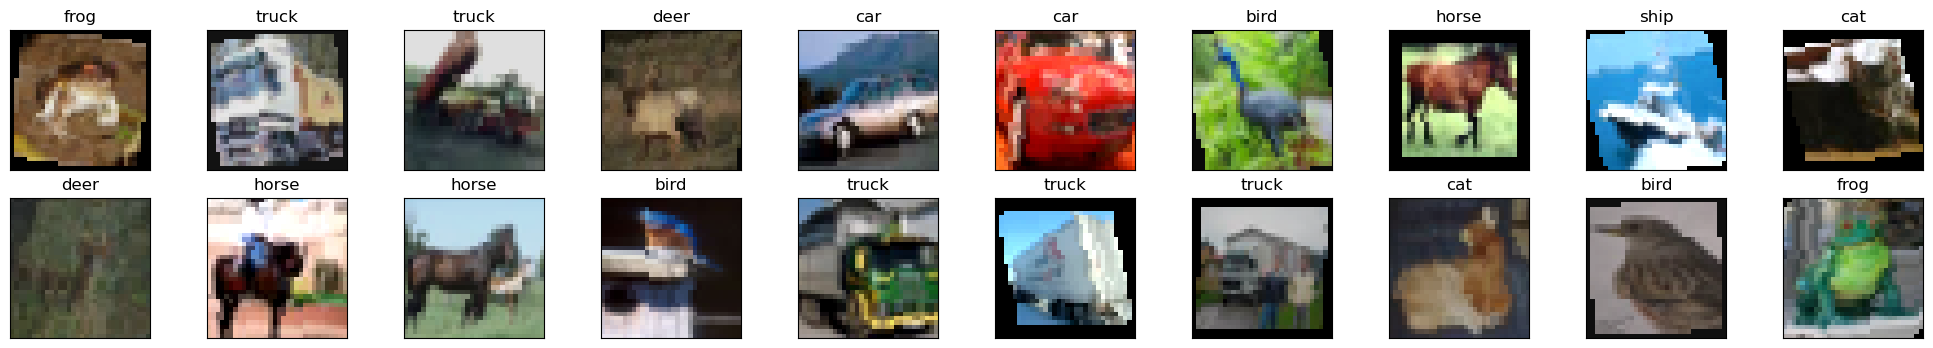

In [32]:
# dataiter = iter(training_loader)
# images, labels = dataiter.next()
# fig = plt.figure(figsize=(25, 4))

# for idx in np.arange(20):
#   ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
#   plt.imshow(im_convert(images[idx]))
#   ax.set_title(classes[labels[idx].item()])
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  image, label = training_dataset[idx]

  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(image))
  ax.set_title(classes[label])

In [33]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      
      return x

In [34]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [36]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.6951, acc 37.4880 
validation loss: 1.3982, validation acc 48.9100 
epoch : 2
training loss: 1.3962, acc 49.2040 
validation loss: 1.2327, validation acc 56.0200 
epoch : 3
training loss: 1.2653, acc 54.7920 
validation loss: 1.1274, validation acc 59.6200 
epoch : 4
training loss: 1.1812, acc 57.7600 
validation loss: 1.0554, validation acc 62.5900 
epoch : 5
training loss: 1.1132, acc 60.7940 
validation loss: 0.9984, validation acc 64.8700 
epoch : 6
training loss: 1.0671, acc 62.2020 
validation loss: 0.9905, validation acc 65.1000 
epoch : 7
training loss: 1.0375, acc 63.5140 
validation loss: 0.9810, validation acc 65.6900 
epoch : 8
training loss: 1.0050, acc 64.2400 
validation loss: 0.9259, validation acc 67.1900 
epoch : 9
training loss: 0.9738, acc 65.9480 
validation loss: 0.9098, validation acc 67.9000 
epoch : 10
training loss: 0.9549, acc 66.2300 
validation loss: 0.8764, validation acc 69.8600 
epoch : 11
training loss: 0.9311, acc 67.4400 
va

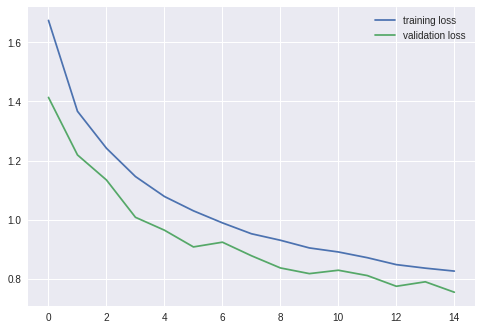

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

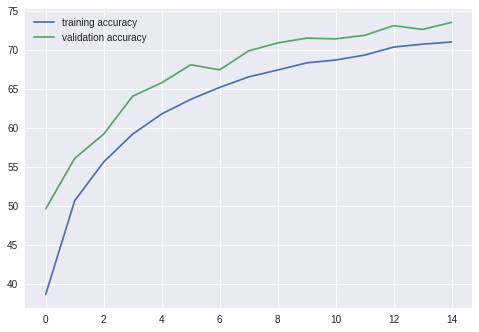

In [ ]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [ ]:
!pip3 install pillow==4.0.0

    100% |████████████████████████████████| 5.6MB 8.3MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


In [ ]:
import PIL.ImageOps

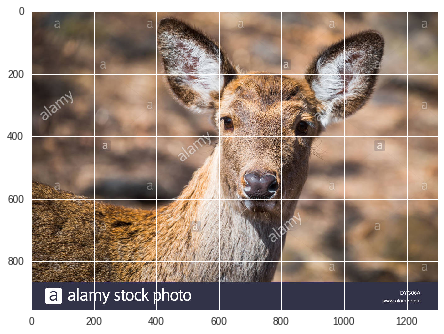

In [ ]:
import requests
from PIL import Image

url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

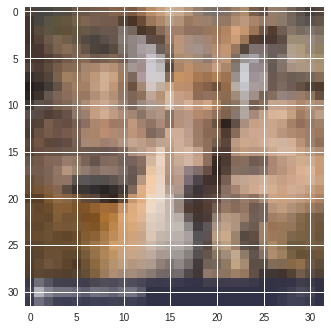

In [ ]:
img = transform(img) 
plt.imshow(im_convert(img))

In [ ]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


In [25]:
# dataiter = iter(validation_loader)
# images, labels = dataiter.next()
# images = images.to(device)
# labels = labels.to(device)
# output = model(images)
# _, preds = torch.max(output, 1)

# fig = plt.figure(figsize=(25, 4))

# for idx in np.arange(20):
#   ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
#   plt.imshow(im_convert(images[idx]))
#   ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  image, label = validation_dataset[idx]

  image = image.to(device)  
  output = model(image)
  _, pred = torch.max(output, 1)
  
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(image))
  ax.set_title("{} ({})".format(str(classes[pred.item()]), str(classes[label])), color=("green" if pred.item() == label else "red"))  

NameError: name 'model' is not defined

<Figure size 2500x400 with 0 Axes>